# Classification Random Forest of Thyroid Dataset

In [30]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np


from sklearn.preprocessing import label_binarize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#helper functions

In [6]:
def parse_row(row):
    row = row.split(".")[0]
    return row

def to_hyperthyroid(row):
    if row != "negative":
        row = "hyperthyroid"
    return row

def to_hypothyroid(row):
    if row != "negative":
        row = "hypothyroid"
    return row

def convert_category(dataframe, column):
    
    if column == 'Sex':
        conditionF = dataframe[column] == 'F' # For sex column
        conditionT = dataframe[column] == 'M' # For sex column
    else:
        conditionF = dataframe[column] == 'f'
        conditionT = dataframe[column] == 't'
    
    dataframe.loc[conditionF, column] = 0
    dataframe.loc[conditionT, column] = 1

# Data Retrival

In [7]:
columns = ["Age", "Sex", "On Thyroxine", "Query on Thyroxine", 
           "On Antithyroid Medication", "Sick", "Pregnant", 
           "Thyroid Surgery", "I131 Treatment", "Query Hypothyroid", 
           "Query Hyperthyroid", "Lithium", "Goitre", "Tumor", 
           "Hypopituitary", "Psych", "TSH Measured", "TSH", "T3 Measured", 
           "T3", "TT4 Measured", "TT4", "T4U Measured", "T4U", 
           "FTI Measured", "FTI", "TBG Measured", "TBG", "Referral Source", "Category"]

In [8]:
hyper_data = pd.read_csv("hypothyroid.csv", names=columns)
hypo_data = pd.read_csv("hypothyroid.csv", names=columns)
sick_data = pd.read_csv("hypothyroid.csv", names=columns)

In [9]:
hyper_data['Category'] = hyper_data['Category'].apply(parse_row).apply(to_hyperthyroid)

hypo_data['Category'] = hypo_data['Category'].apply(parse_row).apply(to_hypothyroid)

sick_data['Category'] = sick_data['Category'].apply(parse_row)

In [10]:
# Combined Thyroid Data

thyroid_frames = [hyper_data, hypo_data, sick_data]
thyroid_data = pd.concat(thyroid_frames).drop_duplicates().drop(['Referral Source', 'TBG', 'TBG Measured'], axis=1)

In [11]:
classes = thyroid_data['Category'].unique()
classes

array(['hyperthyroid', 'hypothyroid', 'binaryClass', 'P', 'N'],
      dtype=object)

In [12]:
print("Number of samples:", len(thyroid_data))

Number of samples: 11136


In [18]:
thyroid_data.head()

,Age,Sex,On Thyroxine,Query on Thyroxine,On Antithyroid Medication,Sick,Pregnant,Thyroid Surgery,I131 Treatment,Query Hypothyroid,...,TSH,T3 Measured,T3,TT4 Measured,TT4,T4U Measured,T4U,FTI Measured,FTI,Category
0,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,hyperthyroid
1,41,F,f,f,f,f,f,f,f,f,...,1.3,t,2.5,t,125,t,1.14,t,109,hyperthyroid
2,23,F,f,f,f,f,f,f,f,f,...,4.1,t,2,t,102,f,?,f,?,hyperthyroid
3,46,M,f,f,f,f,f,f,f,f,...,0.98,f,?,t,109,t,0.91,t,120,hyperthyroid
4,70,F,t,f,f,f,f,f,f,f,...,0.16,t,1.9,t,175,f,?,f,?,hyperthyroid


# Data Cleaning

In [13]:
# Binarize Category Columns
binary_cols = ['On Thyroxine', 'Query on Thyroxine', 'Sex',
               'On Antithyroid Medication', 'Sick', 'Pregnant', 
               'Thyroid Surgery', 'I131 Treatment', 'Query Hypothyroid', 
               'Query Hyperthyroid', 'Lithium', 'Goitre', 'Tumor', 
               'Hypopituitary', 'Psych', 'TSH Measured', 'T3 Measured', 
               'TT4 Measured', 'T4U Measured', 'FTI Measured']

for col in binary_cols: convert_category(thyroid_data, col)

In [14]:
thyroid_data=thyroid_data.drop(0)

In [15]:
# Convert '?' to np.nan and convert numeric data to numeric dtype

for col in thyroid_data.columns: 
    if col != 'Category':
        thyroid_data.loc[thyroid_data[col] == '?', col] = np.nan
        thyroid_data['Age'] = pd.to_numeric(thyroid_data['Age'],errors= 'coerce')

In [16]:
curr_columns = thyroid_data.columns.difference(['Category'])

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_data = imputer.fit_transform(thyroid_data.drop('Category', axis=1))
imputed_data = pd.DataFrame(imputed_data, columns=curr_columns)

thyroid_data = pd.concat([
                    imputed_data.reset_index(), 
                    thyroid_data['Category'].reset_index()], 
                    axis=1).drop('index', axis=1)

In [17]:
for col in thyroid_data.columns: 
    print("Unique of Colum-",col ,"\nUnique values \n",np.sort(thyroid_data[col].unique()))

Unique of Colum- Age 
Unique values 
 [  1.   2.   4.   5.   6.   7.   8.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.
  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94. 455.]
Unique of Colum- FTI 
Unique values 
 [0. 1.]
Unique of Colum- FTI Measured 
Unique values 
 [0. 1.]
Unique of Colum- Goitre 
Unique values 
 [0. 1.]
Unique of Colum- Hypopituitary 
Unique values 
 [0. 1.]
Unique of Colum- I131 Treatment 
Unique values 
 [0. 1.]
Unique of Colum- Lithium 
Unique values 
 [0. 1.]
Unique of Colum- On Antithyroid Medication 
Unique values 
 [0. 1.]
Unique of Colum- On Thyroxine 
Unique values 
 [0. 1.]
Unique of Colum- Pregnant 
Unique values 
 [0. 1.]
Un

# Split Data

In [18]:
X = thyroid_data.drop('Category', axis=1)
y = thyroid_data['Category']

col_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

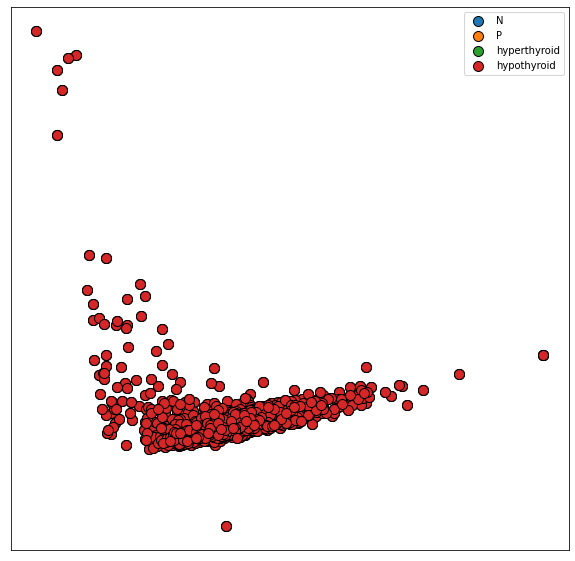

In [19]:
def plot_pca_data(X, y):    
    
    LE = LabelEncoder()
    y_encoded = LE.fit_transform(y)
    
    pca = PCA(n_components=2)
    pca.fit(X)
    pca_X = pca.transform(X)

    x_axis = pca_X[:,0]
    y_axis = pca_X[:,1]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    for label in np.unique(y):
        ax.scatter(pca_X[y==label, 0],
                   pca_X[y==label, 1], 
                   label=label,
                   s=100,
                   edgecolor='k')
        

    ax.legend()
    plt.xticks([])
    plt.yticks([])

plot_pca_data(X, y)

# Parameter of KNN Selection

In [21]:
 # create regressor object
regressor = RandomForestClassifier(n_estimators = 100, criterion='gini', random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(X, y) 

RandomForestClassifier(random_state=0)

In [32]:
from sklearn.pipeline import Pipeline
pipeline= Pipeline([
   ('scaler',StandardScaler()),
    ('pca', PCA()),
   ('clf',RandomForestClassifier(n_estimators=5,max_depth=1,min_samples_leaf=3, max_features=6, random_state=42))
])
pipeline.fit(X_train,y_train)



parameter_grid={'n_estimators':[1,2,3,4,5],'max_depth':[2,4,6,8,10],'min_samples_leaf': 
[1,2,4],'max_features':[1,2,3,4,5,6,7,8]}

number_models=4
random_RandomForest_class=RandomizedSearchCV(
estimator=pipeline['clf'],
param_distributions=parameter_grid,
n_iter=number_models,
scoring='accuracy',
n_jobs=2,
cv=4,
refit=True,
return_train_score=True)

random_RandomForest_class.fit(X_train,y_train)
predictions=random_RandomForest_class.predict(X)

print("Accuracy Score",accuracy_score(y,predictions));
print("Best params",random_RandomForest_class.best_params_)
print("Best score",random_RandomForest_class.best_score_)

Accuracy Score 0.33270457199317344
Best params {'n_estimators': 2, 'min_samples_leaf': 4, 'max_features': 1, 'max_depth': 4}
Best score 0.32974034664507706


# Classify on Test Set

In [33]:
#predicting on the test set and creating submission file
 # create regressor object
regressor = RandomForestClassifier(n_estimators = 2, min_samples_leaf= 4, max_features= 1, max_depth= 4)
 
# fit the regressor with x and y data
regressor.fit(X, y) 

y_pred = regressor.predict(X_test)

accuracy = regressor.score(X,y)
print( 'Random Forest Accuracy: ', accuracy*100,'%')


"""
#data_pred
model = KNeighborsClassifier(n_neighbors = 159)
model.fit(X_train, y_train)  #fit the 


accuracy=model.score(X_test, y_test)*100

print("\nAccuracy of Model is :",accuracy)


y_true, y_pred = y_test, model.predict(X_test)

"""
"""
##
y_true, y_pred = y_test, svm_clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("*"*50)
print()
print("\t\t\tClassification Report")
print()
print(classification_report(y_true, y_pred))
"""

['hyperthyroid' 'hyperthyroid' 'hypothyroid' ... 'hyperthyroid'
 'hyperthyroid' 'hypothyroid']
Random Forest Accuracy:  33.2884218090362 %


'\n##\ny_true, y_pred = y_test, svm_clf.predict(X_test)\n\nprint("Accuracy:",accuracy_score(y_test, y_pred))\nprint("*"*50)\nprint()\nprint("\t\t\tClassification Report")\nprint()\nprint(classification_report(y_true, y_pred))\n'

In [34]:
# Confusion Matrix
y_true, y_pred = y_test, regressor.predict(X_test)
cm = confusion_matrix(y_true, y_pred, labels=classes)
print(cm)

[[151 738   0  39   0]
 [162 744   0  22   0]
 [  0   0   0   0   0]
 [159 659   0  37   0]
 [  9  63   0   1   0]]
